<a href="https://colab.research.google.com/github/yyduyuxuan/Machine-Learning-for-Data-Driven-Inventory-Replenishment-Evidence-from-the-M5-Retail-Dataset/blob/main/TRAIN_State_Dept_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [ ]:
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2)

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [ ]:
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

file_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_5y.pkl'
sales_long_val = pd.read_pickle(file_path)

print(sales_long_val.shape)
sales_long_val.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(45974682, 119)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,enc_std_store_id_dept_id,enc_mean_item_id,enc_std_item_id,enc_mean_item_id_state_id,enc_std_item_id_state_id,enc_mean_item_id_store_id,enc_std_item_id_store_id,ROP_L3,ROP_L7,ROP_L14
0,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,3,2011-01-29,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,NaN,NaN,NaN
1,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2,0,2011-01-30,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,NaN,NaN,NaN
2,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0,2011-01-31,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,5.0,NaN,NaN
3,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,1,2011-02-01,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,7.0,NaN,NaN
4,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,5,4,2011-02-02,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,6.0,NaN,NaN


In [ ]:
# Group
group_key = ['state_id', 'dept_id']

group_names = sales_long_val[group_key].drop_duplicates().values.tolist()
print(f"Total groups: {len(group_names)}")

Total groups: 21


# Data grouping

In [ ]:
# Remove features not used in training (usually unique identifiers, raw fields)
remove_feature = [
    'id',
    'state_id',
    #'store_id',
    #'cat_id',
    #'item_id',
    'dept_id',
    'date',
    'd',
    'wm_yr_wk',
    'sales'
]

# Build a set of categorical variables (including original + new)
cat_var = [
    'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id',
    'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2',
    'snap_CA', 'snap_TX', 'snap_WI',
    'is_weekend',
    'price_change_flag',
    'is_discontinued'
]

# Remove those features we marked as "remove_feature"
cat_var = list(set(cat_var) - set(remove_feature))

# Finally, cat_var is the list of category variables
print("Final categorical variables used for training:")
print(cat_var)

Final categorical variables used for training:
['price_change_flag', 'store_id', 'is_weekend', 'snap_CA', 'event_name_1', 'is_discontinued', 'event_type_2', 'snap_WI', 'event_type_1', 'event_name_2', 'item_id', 'cat_id', 'snap_TX']


In [ ]:
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'date', 'wm_yr_wk']
lag_features = [
    'lag_1', 'lag_7', 'lag_14', 'lag_28',
    'lag_29', 'lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34',
    'lag_35', 'lag_36', 'lag_37', 'lag_38', 'lag_39', 'lag_40',
    'lag_41', 'lag_42'
]
lag_diff_features = ['lag_1_minus_7', 'lag_7_minus_14', 'lag_14_minus_28']

rolling_features = [
    'rolling_mean_7', 'rolling_std_7',
    'rolling_mean_14', 'rolling_std_14',
    'rolling_mean_30', 'rolling_std_30',
    'rolling_mean_60', 'rolling_std_60',
    'rolling_mean_180', 'rolling_std_180'
]

rolling_tmp_features = [
    'rolling_mean_tmp_1_7', 'rolling_mean_tmp_1_14', 'rolling_mean_tmp_1_30', 'rolling_mean_tmp_1_60',
    'rolling_mean_tmp_7_7', 'rolling_mean_tmp_7_14', 'rolling_mean_tmp_7_30', 'rolling_mean_tmp_7_60',
    'rolling_mean_tmp_14_7', 'rolling_mean_tmp_14_14', 'rolling_mean_tmp_14_30', 'rolling_mean_tmp_14_60'
]

intermittency_features = ['ADI_30', 'CV2_30', 'ADI_60', 'CV2_60', 'ADI_90', 'CV2_90']

time_features = ['weekday', 'wday', 'month', 'year', 'day_of_year', 'sin_doy', 'cos_doy',
                 'tm_w', 'tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end', 'is_weekend']

event_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
                  'snap_CA', 'snap_TX', 'snap_WI']

price_features = [
    'sell_price', 'price_lag_7', 'price_change_flag', 'price_max', 'price_min',
    'price_mean', 'price_std', 'price_norm', 'price_nunique', 'item_nunique',
    'price_momentum', 'price_momentum_m', 'price_momentum_y'
]

lifecycle_features = ['release', 'is_discontinued']


mean_encoding_features = [
    'enc_mean_state_id', 'enc_std_state_id',
    'enc_mean_store_id', 'enc_std_store_id',
    'enc_mean_cat_id', 'enc_std_cat_id',
    'enc_mean_dept_id', 'enc_std_dept_id',
    'enc_mean_state_id_cat_id', 'enc_std_state_id_cat_id',
    'enc_mean_state_id_dept_id', 'enc_std_state_id_dept_id',
    'enc_mean_store_id_cat_id', 'enc_std_store_id_cat_id',
    'enc_mean_store_id_dept_id', 'enc_std_store_id_dept_id',
    'enc_mean_item_id', 'enc_std_item_id',
    'enc_mean_item_id_state_id', 'enc_std_item_id_state_id',
    'enc_mean_item_id_store_id', 'enc_std_item_id_store_id'
]

In [ ]:
feature_cols = (
    lag_features + lag_diff_features + rolling_features + rolling_tmp_features +
    intermittency_features + time_features + event_features + price_features +
    lifecycle_features + mean_encoding_features
)

# ML Forecasting

In [ ]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from tqdm import tqdm

# LightGBM Parameter settings
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'subsample': 0.7,
    'subsample_freq': 1,
    'learning_rate': 0.02,
    'num_leaves': 2**7 - 1,
    'min_data_in_leaf': 2**6 - 1,
    'feature_fraction': 0.7,
    'max_bin': 100,
    'n_estimators': 2500,
    'boost_from_average': False,
    'verbose': -1,
    'seed': 1995
}


In [ ]:
from sklearn.preprocessing import LabelEncoder

for col in ['item_id', 'cat_id', 'store_id', 'weekday']:
    if sales_long_val[col].dtype == 'object':
        le = LabelEncoder()
        sales_long_val[col] = le.fit_transform(sales_long_val[col])


In [ ]:
!pip install tqdm

# Result & Model Save

In [ ]:
label_col = 'ROP_L3'
group_key = ['state_id', 'dept_id']
remove_feature=[
        # ID
        'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
        'd', 'date', 'wm_yr_wk','sales',

        # ROP label
        'ROP_L3', 'ROP_L7', 'ROP_L14',

        # mean encoding, avoid target leakage
        'enc_mean_state_id', 'enc_std_state_id',
        'enc_mean_dept_id', 'enc_std_dept_id',
        'enc_mean_state_id_cat_id', 'enc_std_state_id_cat_id',
        'enc_mean_state_id_dept_id', 'enc_std_state_id_dept_id',
        'enc_mean_store_id_dept_id', 'enc_std_store_id_dept_id',
        'enc_mean_item_id_state_id', 'enc_std_item_id_state_id']

In [ ]:
sales_long_val[['item_id','store_id','id']].head(), sales_long_val.dtypes[['item_id','store_id','id']]

(   item_id  store_id                           id
 0        0         0  FOODS_1_001_CA_1_validation
 1        0         0  FOODS_1_001_CA_1_validation
 2        0         0  FOODS_1_001_CA_1_validation
 3        0         0  FOODS_1_001_CA_1_validation
 4        0         0  FOODS_1_001_CA_1_validation,
 item_id      int64
 store_id     int64
 id          object
 dtype: object)

In [ ]:
import os, gc, pickle, time
import numpy as np
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm


# Drop training period constant to avoid LGB instability
def _fit_lgb_safe(X_tr, y_tr, params):
    n = X_tr.shape[0]
    const_cols = [c for c in X_tr.columns if X_tr[c].nunique(dropna=True) <= 1]
    if const_cols:
        X_tr = X_tr.drop(columns=const_cols)

    safe = dict(params or {})
    safe['min_data_in_leaf'] = max(5, min(safe.get('min_data_in_leaf', 20), max(2, n // 4)))
    safe['num_leaves']       = min(safe.get('num_leaves', 31), max(2, n - 1))
    safe['force_row_wise']   = True

    mdl = lgb.LGBMRegressor(**safe)
    mdl.fit(X_tr, y_tr)
    return mdl, const_cols


# Calculate the d boundary of "3 years of training + validation = the last 3 months of Y4" (automatically do a robust mapping of date → d)
def make_ranges_train3y_val_last3m(df, date_col='date', d_col='d', lead_time=3):
    dd = df[[date_col, d_col]].drop_duplicates().sort_values(date_col)
    if not np.issubdtype(dd[date_col].dtype, np.datetime64):
        dd[date_col] = pd.to_datetime(dd[date_col])

    start  = dd[date_col].min().normalize()
    y4_end = start + pd.DateOffset(years=4) - pd.Timedelta(days=1)

    # The day following the last three months of the year ending in Y4 (val start)
    val_start_date   = (y4_end - pd.DateOffset(months=3)) + pd.Timedelta(days=1)
    # 3 years before the verification starting point (train start)
    train_start_date = val_start_date - pd.DateOffset(years=3)

    # Date → d (take the minimum d >= starting point and the maximum d <= end point)
    d_val_start   = int(dd.loc[dd[date_col] >= val_start_date,   d_col].min())
    d_y4_end      = int(dd.loc[dd[date_col] <= y4_end,           d_col].max())
    d_train_start = int(dd.loc[dd[date_col] >= train_start_date, d_col].min())

    L = int(lead_time)
    d_train_end = d_val_start - L
    d_val_end   = d_y4_end    - (L - 1)

    if d_train_end < d_train_start:
        raise ValueError("The 3-year training window is insufficient.")

   # Record meta
    date_at = dd.drop_duplicates(d_col).set_index(d_col)[date_col]
    info = {
        "y4_end_date":       y4_end.date(),
        "train_start_d":     int(d_train_start),
        "train_end_d":       int(d_train_end),
        "val_start_d":       int(d_val_start),
        "val_end_d":         int(d_val_end),
        "train_start_date":  pd.to_datetime(date_at.loc[d_train_start]).date(),
        "train_end_date":    pd.to_datetime(date_at.loc[d_train_end]).date(),
        "val_start_date":    pd.to_datetime(date_at.loc[d_val_start]).date(),
        "val_end_date":      pd.to_datetime(date_at.loc[d_val_end]).date(),
        "lead_time":         L
    }
    return (int(d_train_start), int(d_train_end)), (int(d_val_start), int(d_val_end)), info


# Main Function
def run_train_val_train3y_val_last3m(
    df, group_key, label_col, remove_feature, lgb_params,
    forecast_dir, model_dir,
    date_col='date', d_col='d', lead_time=3
):
    os.makedirs(forecast_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

    train_range, val_range, info = make_ranges_train3y_val_last3m(
        df, date_col=date_col, d_col=d_col, lead_time=lead_time
    )
    print(f"[SPLIT] Train: d[{train_range[0]}, {train_range[1]}] "
          f"({info['train_start_date']} → {info['train_end_date']})")
    print(f"        Val  : d[{val_range[0]}, {val_range[1]}] "
          f"({info['val_start_date']} → {info['val_end_date']})")

    # Save meta
    with open(os.path.join(forecast_dir, "cv_meta.pkl"), "wb") as f:
        pickle.dump({
            "mode": "train=3y, val=Y4 last 3 months (no Y5)",
            **info,
            "date_col": date_col,
            "d_col": d_col,
            "group_key": group_key,
            "target_col": label_col
        }, f)

    # Train by group
    group_vals_list = df[group_key].drop_duplicates().itertuples(index=False, name=None)
    for gvals in tqdm(list(group_vals_list), desc="Hold-out per group", unit="group"):
        group_id = "_".join(map(str, gvals))
        f_path = os.path.join(forecast_dir, f"forecast_{group_id}.pkl")
        m_path = os.path.join(model_dir,    f"model_{group_id}.bin")
        if os.path.exists(f_path) and os.path.exists(m_path):
            tqdm.write(f"[Skip] {group_id} already processed.")
            continue

        gmask = np.ones(len(df), dtype=bool)
        for k, v in zip(group_key, gvals):
            gmask &= (df[k] == v)
        gdf = (df.loc[gmask]
                 .sort_values(d_col)
                 .reset_index()
                 .rename(columns={'index': 'row_idx'}))

        tr_mask = (gdf[d_col] >= train_range[0]) & (gdf[d_col] <= train_range[1])
        vl_mask = (gdf[d_col] >= val_range[0])   & (gdf[d_col] <= val_range[1])
        y_tr = gdf.loc[tr_mask, label_col].dropna()
        X_tr = gdf.loc[y_tr.index].drop(columns=remove_feature + [label_col], errors='ignore')

        y_vl = gdf.loc[vl_mask, label_col].dropna()
        X_vl = gdf.loc[y_vl.index].drop(columns=remove_feature + [label_col], errors='ignore')

        if X_tr.empty or X_vl.empty:
            tqdm.write(f"[Warn] {group_id} no train/val rows. Skipped.")
            continue

        # Train
        if os.path.exists(m_path):
            with open(m_path, 'rb') as f:
                model = pickle.load(f)
            dropped_cols = []
            secs = np.nan
        else:
            t0 = time.time()
            model, dropped_cols = _fit_lgb_safe(X_tr, y_tr, lgb_params)
            secs = time.time() - t0
            with open(m_path, 'wb') as f:
                pickle.dump(model, f)

        # Val
        X_vl2 = X_vl.drop(columns=dropped_cols, errors='ignore')
        train_feats = list(model.feature_name_)
        X_vl2 = X_vl2.reindex(columns=train_feats, fill_value=0)
        pred = model.predict(X_vl2)

        # Save results & models
        rows_vl   = gdf.loc[y_vl.index, 'row_idx']
        cols_keep = ['d', 'date'] + [c for c in (['item_id','store_id'] + list(group_key)) if c in df.columns]

        out = df.loc[rows_vl, cols_keep].copy()
        out['true']       = y_vl.values
        out['pred']       = pred
        out['train_secs'] = secs
        out.to_pickle(f_path)

        tqdm.write(f"[Save] Forecast -> {f_path}")
        tqdm.write(f"[Save] Model    -> {m_path}")

        del gdf, X_tr, y_tr, X_vl, y_vl, model, out
        gc.collect()

    print("[DONE] Train=3y, Val=last 3 months of Y4 (label-safe, no Y5). Meta saved as cv_meta.pkl")

In [ ]:
forecast_dir = "/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/"
model_dir    = "/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/"

run_train_val_train3y_val_last3m(
    df=sales_long_val,
    group_key=group_key,
    label_col='ROP_L3',
    remove_feature=remove_feature,
    lgb_params=lgb_params,
    forecast_dir=forecast_dir,
    model_dir=model_dir,
    date_col='date',
    d_col='d',
    lead_time=3
)

[SPLIT] Train: d[274, 1367] (2011-10-29 → 2014-10-26)
        Val  : d[1370, 1459] (2014-10-29 → 2015-01-26)


Hold-out per group:   5%|▍         | 1/21 [01:46<35:25, 106.28s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_CA_FOODS_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_CA_FOODS_1.bin


Hold-out per group:  10%|▉         | 2/21 [03:26<32:28, 102.53s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_TX_FOODS_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_TX_FOODS_1.bin


Hold-out per group:  14%|█▍        | 3/21 [04:55<28:58, 96.60s/group] 

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_WI_FOODS_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_WI_FOODS_1.bin


Hold-out per group:  19%|█▉        | 4/21 [07:02<30:47, 108.70s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_CA_FOODS_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_CA_FOODS_2.bin


Hold-out per group:  24%|██▍       | 5/21 [09:01<29:58, 112.42s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_TX_FOODS_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_TX_FOODS_2.bin


Hold-out per group:  29%|██▊       | 6/21 [10:57<28:20, 113.34s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_WI_FOODS_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_WI_FOODS_2.bin


Hold-out per group:  33%|███▎      | 7/21 [15:00<36:23, 155.98s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_CA_FOODS_3.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_CA_FOODS_3.bin


Hold-out per group:  38%|███▊      | 8/21 [18:14<36:21, 167.83s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_TX_FOODS_3.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_TX_FOODS_3.bin


Hold-out per group:  43%|████▎     | 9/21 [21:27<35:08, 175.70s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_WI_FOODS_3.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_WI_FOODS_3.bin


Hold-out per group:  48%|████▊     | 10/21 [24:16<31:52, 173.82s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_CA_HOBBIES_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_CA_HOBBIES_1.bin


Hold-out per group:  52%|█████▏    | 11/21 [26:34<27:07, 162.71s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_TX_HOBBIES_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_TX_HOBBIES_1.bin


Hold-out per group:  57%|█████▋    | 12/21 [28:55<23:26, 156.25s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_WI_HOBBIES_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_WI_HOBBIES_1.bin


Hold-out per group:  62%|██████▏   | 13/21 [30:20<17:56, 134.62s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_CA_HOBBIES_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_CA_HOBBIES_2.bin


Hold-out per group:  67%|██████▋   | 14/21 [31:36<13:38, 116.88s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_TX_HOBBIES_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_TX_HOBBIES_2.bin


Hold-out per group:  71%|███████▏  | 15/21 [32:50<10:23, 103.90s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_WI_HOBBIES_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_WI_HOBBIES_2.bin


Hold-out per group:  76%|███████▌  | 16/21 [35:44<10:25, 125.13s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_CA_HOUSEHOLD_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_CA_HOUSEHOLD_1.bin


Hold-out per group:  81%|████████  | 17/21 [38:05<08:38, 129.71s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_TX_HOUSEHOLD_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_TX_HOUSEHOLD_1.bin


Hold-out per group:  86%|████████▌ | 18/21 [40:25<06:39, 133.07s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_WI_HOUSEHOLD_1.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_WI_HOUSEHOLD_1.bin


Hold-out per group:  90%|█████████ | 19/21 [43:48<05:07, 153.94s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_CA_HOUSEHOLD_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_CA_HOUSEHOLD_2.bin


Hold-out per group:  95%|█████████▌| 20/21 [46:23<02:34, 154.38s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_TX_HOUSEHOLD_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_TX_HOUSEHOLD_2.bin


Hold-out per group: 100%|██████████| 21/21 [48:57<00:00, 139.88s/group]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/forecast_WI_HOUSEHOLD_2.pkl
[Save] Model    -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_state_dept_3y_train/model_WI_HOUSEHOLD_2.bin
[DONE] Train=3y, Val=last 3 months of Y4 (label-safe, no Y5). Meta saved as cv_meta.pkl


In [ ]:
import pandas as pd
import os
from glob import glob
from google.colab import drive
drive.mount('/content/drive')

new_results_dir = "/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/"

file_list = glob(os.path.join(new_results_dir, "forecast_*.pkl"))

all_results = pd.concat([pd.read_pickle(f) for f in file_list], ignore_index=True)

all_results.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,d,date,item_id,store_id,state_id,dept_id,true,pred,train_secs
0,1370,2014-10-29,85,0,CA,FOODS_1,2.0,8.776233,87.400752
1,1370,2014-10-29,84,0,CA,FOODS_1,17.0,16.554994,87.400752
2,1370,2014-10-29,74,1,CA,FOODS_1,3.0,4.676525,87.400752
3,1370,2014-10-29,184,3,CA,FOODS_1,7.0,3.279407,87.400752
4,1370,2014-10-29,62,0,CA,FOODS_1,3.0,2.506802,87.400752


In [ ]:
keys = ['d','state_id','dept_id','item_id','store_id']
map_cols = keys + ['id']

mapping = (sales_long_val[map_cols]
           .drop_duplicates())

for k in keys:
    if k in all_results.columns and mapping[k].dtype != all_results[k].dtype:
        mapping[k] = mapping[k].astype(all_results[k].dtype)

all_results = all_results.merge(mapping, on=keys, how='left', validate='m:1')

m = (all_results['id'].astype(str)
       .str.extract(r'^(?P<item_name>.*)_(?P<store_name>[A-Z]{2}_\d+)_(?P<split>validation|evaluation)$'))

all_results['item_name']  = m['item_name']
all_results['store_name'] = m['store_name']

all_results.head()

,d,date,item_id,store_id,state_id,dept_id,true,pred,train_secs,id,item_name,store_name
0,1370,2014-10-29,85,0,CA,FOODS_1,2.0,8.776233,87.400752,FOODS_1_087_CA_1_validation,FOODS_1_087,CA_1
1,1370,2014-10-29,84,0,CA,FOODS_1,17.0,16.554994,87.400752,FOODS_1_086_CA_1_validation,FOODS_1_086,CA_1
2,1370,2014-10-29,74,1,CA,FOODS_1,3.0,4.676525,87.400752,FOODS_1_076_CA_2_validation,FOODS_1_076,CA_2
3,1370,2014-10-29,184,3,CA,FOODS_1,7.0,3.279407,87.400752,FOODS_1_188_CA_4_validation,FOODS_1_188,CA_4
4,1370,2014-10-29,62,0,CA,FOODS_1,3.0,2.506802,87.400752,FOODS_1_064_CA_1_validation,FOODS_1_064,CA_1


In [ ]:
ar = all_results.copy()

# Rename
if 'item_name' in ar.columns:
    ar.drop(columns=[c for c in ['item_id'] if c in ar.columns], inplace=True)
    ar.rename(columns={'item_name': 'item_id'}, inplace=True)

if 'store_name' in ar.columns:
    ar.drop(columns=[c for c in ['store_id'] if c in ar.columns], inplace=True)
    ar.rename(columns={'store_name': 'store_id'}, inplace=True)


for c in ['item_id', 'store_id']:
    if c in ar.columns:
        ar[c] = ar[c].astype(str)

# target cols
order = ['d', 'date', 'item_id', 'store_id', 'state_id', 'dept_id', 'true', 'pred', 'train_secs']

ar = ar[[c for c in order if c in ar.columns] + [c for c in ar.columns if c not in order]]

all_results = ar

all_results.head()

,d,date,item_id,store_id,state_id,dept_id,true,pred,train_secs,id
0,1370,2014-10-29,FOODS_1_087,CA_1,CA,FOODS_1,2.0,8.776233,87.400752,FOODS_1_087_CA_1_validation
1,1370,2014-10-29,FOODS_1_086,CA_1,CA,FOODS_1,17.0,16.554994,87.400752,FOODS_1_086_CA_1_validation
2,1370,2014-10-29,FOODS_1_076,CA_2,CA,FOODS_1,3.0,4.676525,87.400752,FOODS_1_076_CA_2_validation
3,1370,2014-10-29,FOODS_1_188,CA_4,CA,FOODS_1,7.0,3.279407,87.400752,FOODS_1_188_CA_4_validation
4,1370,2014-10-29,FOODS_1_064,CA_1,CA,FOODS_1,3.0,2.506802,87.400752,FOODS_1_064_CA_1_validation


In [ ]:
all_results.to_pickle("/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/all_results.pkl")


In [ ]:
print(f"Total records: {all_results.shape[0]}")
print(f"Columns: {all_results.columns.tolist()}")

Total records: 2650184
Columns: ['d', 'date', 'item_id', 'store_id', 'state_id', 'dept_id', 'true', 'pred', 'train_secs', 'id']


# Evaluation with errors

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

def calculate_test_errors(test_series, forecast_series, train_series=None,
                          series_name='y', model_name='model', print_results=False):

    y_true = np.array(test_series)
    y_pred = np.array(forecast_series)

    # MAPE and sMAPE（escape 0）
    skip_mape = (y_true == 0).any()
    if not skip_mape:
        mape_val = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        smape_val = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

    # RMSE
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    me_val = np.mean(y_pred - y_true)
    mean_test = np.mean(y_true)
    norm_rmse = rmse_val / mean_test
    norm_me = me_val / mean_test

    # RMSSE
    if train_series is not None:
        y_train = np.array(train_series)
        insample_naive = np.mean((y_train[1:] - y_train[:-1]) ** 2)
        rmsse_val = rmse_val / np.sqrt(insample_naive) if insample_naive > 0 else np.nan
    else:
        rmsse_val = np.nan

    if print_results:
        print(f"Model: {model_name} | Series: {series_name}")
        if not skip_mape:
            print(f"MAPE     : {mape_val:.2f}%")
            print(f"sMAPE    : {smape_val:.2f}%")
        print(f"RMSSE    : {rmsse_val:.3f}")
        print(f"RMSE     : {rmse_val:.3f}")
        print(f"Norm_RMSE: {norm_rmse:.3f}")
        print(f"ME       : {me_val:.3f}")
        print(f"Norm_ME  : {norm_me:.3f}")

    # DataFrame
    if not skip_mape:
        columns = ['SeriesName', 'Model', 'MAPE', 'sMAPE', 'RMSSE', 'RMSE', 'Norm_RMSE', 'ME', 'Norm_ME']
        values = [series_name, model_name, mape_val, smape_val, rmsse_val, rmse_val, norm_rmse, me_val, norm_me]
    else:
        columns = ['SeriesName', 'Model', 'RMSSE', 'RMSE', 'Norm_RMSE', 'ME', 'Norm_ME']
        values = [series_name, model_name, rmsse_val, rmse_val, norm_rmse, me_val, norm_me]

    return pd.DataFrame([values], columns=columns)


In [ ]:
def evaluate_group_errors(
    result_df: pd.DataFrame,
    sales_long_val: pd.DataFrame,
    label_col: str,
    group_key: list,
    train_range: tuple,               # from cv_meta (train_start_d, train_end_d)
    lead_time: int = 3,
    model_name: str = 'ML_Holdout'
):
    error_summary = []
    tr_start, tr_end = train_range

    result_df = result_df.dropna(subset=['true','pred'])

    for group_vals, gpred in result_df.groupby(group_key, sort=False):
        y_true = gpred['true'].to_numpy(dtype=float)
        y_pred = gpred['pred'].to_numpy(dtype=float)

        # historical data in train set
        mask = np.ones(len(sales_long_val), dtype=bool)
        for k, v in zip(group_key, (group_vals if isinstance(group_vals, tuple) else (group_vals,))):
            mask &= (sales_long_val[k] == v)
        mask &= (sales_long_val['d'] >= tr_start) & (sales_long_val['d'] <= tr_end)

        g_hist = sales_long_val.loc[mask, ['d','sales']].sort_values('d')
        if g_hist.empty:
            train_series = None
        else:
            if 'ROP' in label_col.upper():
                # rolling L day sum, shifted forward (L-1) to prevent leakage
                rop_train = (
                    g_hist['sales'] # The daily sales series for the current group within the training window, sorted by day
                    .shift(-(lead_time - 1)) # Negative shift moves the series upwards (earlier), index t looking at data from t+L-1 days ahead
                    .rolling(lead_time)
                    .sum() # Within each rolling window, sum the L values
                )
                last_t = tr_end - (lead_time - 1)
                train_series = rop_train[g_hist['d'] <= last_t].dropna()
            else:
                train_series = g_hist['sales'].dropna()

            if train_series is not None and len(train_series) < 2:
                train_series = None

        res = calculate_test_errors(
            test_series=y_true,
            forecast_series=y_pred,
            train_series=train_series,
            series_name=str(group_vals),
            model_name=model_name,
            print_results=False
        )
        error_summary.append(res)

    return pd.concat(error_summary, ignore_index=True) if error_summary else pd.DataFrame()


In [ ]:
total_nan_rows = 0

for group_vals, group_df in all_results.groupby(group_key):
    nan_mask = group_df[['true', 'pred']].isna().any(axis=1)
    nan_count = nan_mask.sum()

    if nan_count > 0:
        print(f"Group {group_vals} has {nan_count} NaN rows.")
        total_nan_rows += nan_count

print(f"\n✅ Total rows with NaN in 'true' or 'pred': {total_nan_rows}")



✅ Total rows with NaN in 'true' or 'pred': 0


In [ ]:
nan_rows = all_results[['true', 'pred']].isna().any(axis=1).sum()

total_rows = len(all_results)

nan_ratio = nan_rows / total_rows

print(f"Number of rows containing NaNs: {nan_rows}")
print(f"Total number of rows: {total_rows}")
print(f"NaN percentage: {nan_ratio:.2%}")


Number of rows containing NaNs: 30379
Total number of rows: 4253060
NaN percentage: 0.71%


In [ ]:
import os
import pickle
results_dir = "/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/"


with open(os.path.join(results_dir, "cv_meta.pkl"), "rb") as f:
    meta = pickle.load(f)

train_range = (meta["train_start_d"], meta["train_end_d"])
val_range   = (meta["val_start_d"],   meta["val_end_d"])
print("train_range d =", train_range, "| val_range d =", val_range)

# Call
err_train = evaluate_group_errors(
    result_df=all_results,
    sales_long_val=sales_long_val,
    label_col=label_col,
    group_key=group_key,
    train_range=train_range,
    lead_time=3,
    model_name='ML_3y'
)

err_train.head()

train_range d = (274, 1367) | val_range d = (1370, 1459)


,SeriesName,Model,RMSSE,RMSE,Norm_RMSE,ME,Norm_ME
0,"('CA', 'FOODS_1')",ML_3y,0.922065,4.591634,1.038626,-0.245392,-0.055508
1,"('TX', 'FOODS_1')",ML_3y,0.865311,4.013489,1.156247,-0.337285,-0.097169
2,"('WI', 'FOODS_1')",ML_3y,0.838133,3.964851,1.108268,-0.299543,-0.083729
3,"('CA', 'FOODS_2')",ML_3y,0.661289,3.036842,0.844256,-0.017027,-0.004734
4,"('TX', 'FOODS_2')",ML_3y,0.793098,2.901106,1.000422,-0.163040,-0.056223


In [ ]:
err_train.head(20)

,SeriesName,Model,RMSSE,RMSE,Norm_RMSE,ME,Norm_ME
0,"('CA', 'FOODS_1')",ML_3y,0.694525,3.458547,0.782156,-0.165977,-0.037536
1,"('TX', 'FOODS_1')",ML_3y,0.635838,2.949149,0.850109,-0.202008,-0.058230
2,"('WI', 'FOODS_1')",ML_3y,0.616227,2.915107,0.816481,-0.166266,-0.046569
3,"('CA', 'FOODS_2')",ML_3y,0.513053,2.356097,0.654881,-0.002863,-0.000796
4,"('TX', 'FOODS_2')",ML_3y,0.600954,2.198253,0.758486,-0.087021,-0.030026
5,"('WI', 'FOODS_2')",ML_3y,0.577530,2.923737,0.709336,-0.099604,-0.024165
6,"('CA', 'FOODS_3')",ML_3y,0.374552,4.349692,0.672213,-0.007118,-0.001100
7,"('TX', 'FOODS_3')",ML_3y,0.367365,3.979533,0.706846,-0.062464,-0.011095
8,"('WI', 'FOODS_3')",ML_3y,0.542674,5.181997,0.859774,-0.072678,-0.012058
9,"('CA', 'HOBBIES_1')",ML_3y,0.758741,3.239946,1.211201,-0.052226,-0.019524


In [ ]:
err_train.to_pickle("/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_state_dept_3y_train/err_train_state_dept.pkl")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_true_vs_pred(df_forecast, true_col='true', pred_col='pred', n_points=140, title='Prediction vs True'):
    plt.figure(figsize=(18, 6))
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Value")


    y_true = df_forecast[true_col][-n_points:]
    y_pred = df_forecast[pred_col][-n_points:]

    sns.lineplot(x=y_true.index, y=y_true.values, label='True', color='black')
    sns.lineplot(x=y_pred.index, y=y_pred.values, label='Prediction', color='blue')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
sample_group_df = all_results[
    (all_results['state_id'] == 'CA') &
    (all_results['dept_id'] == 'FOODS_1')
]


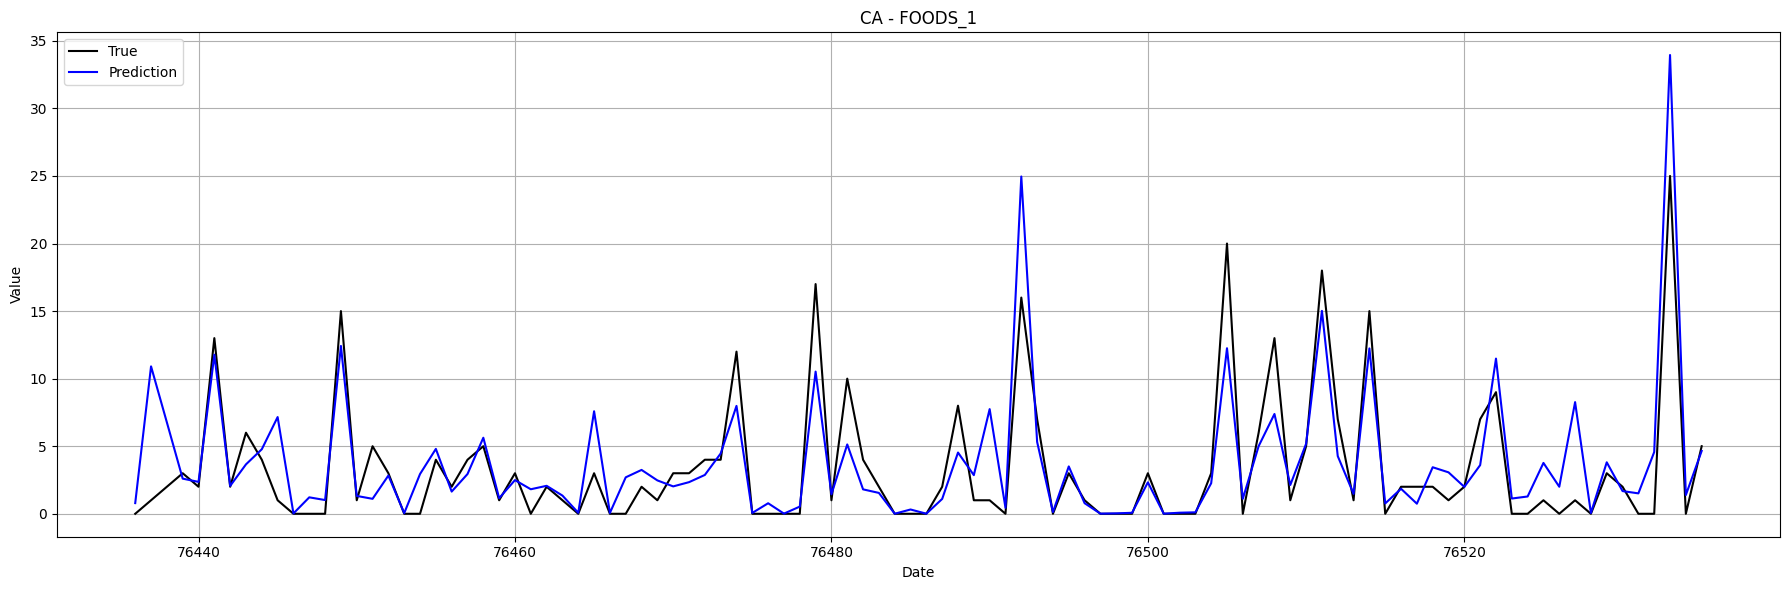

In [ ]:
plot_true_vs_pred(sample_group_df, true_col='true', pred_col='pred', n_points=100, title='CA - FOODS_1')
